# Estimating ECM Parameters, Running a PyBaMM simulation, & Performing Sensitivity Analysis

This notebook provides example usage for estimating stationary parameters for a two RC branch Thevenin model. With the estimated parameters, a thermal model is created and predictions are made. A sensitivity analysis is also performed using Python's SALib module.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [17]:
%pip install --upgrade pip ipywidgets openpyxl pandas -q
%pip install pybop -q

import time as _time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybamm
from pybamm import Parameter
from SALib.analyze import morris as morris_analyze
from SALib.analyze import sobol
from SALib.sample import morris as morris_sample
from SALib.sample import sobol as sobol_sample

import pybop

pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"

/usr/lib/python3.12/pty.py:95: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In this example, we use the default parameter value for the `"Open-circuit voltage [V]"` as provided by the original PyBaMM class. To update this, provide a function definition that matches this [function](https://github.com/pybamm-team/PyBaMM/blob/1943aa5ab2895b5378220595923dbae3d66b13c9/pybamm/input/parameters/ecm/example_set.py#L17). First, we define the model class with two RC elements, and then load and update the ECM input parameters,

In [18]:
model = pybamm.equivalent_circuit.Thevenin(options={"number of rc elements": 2})
parameter_values = pybamm.ParameterValues("ECM_Example")
parameter_values.update(
    {
        "Cell capacity [A.h]": 3,
        "Nominal cell capacity [A.h]": 3,
        "Element-1 initial overpotential [V]": 0,
        "Element-2 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 2.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 0.1,
        "R2 [Ohm]": 0.001,
        "Tau1 [s]": 1.0,
        "Tau2 [s]": 100.0,
        "C1 [F]": Parameter("Tau1 [s]") / (Parameter("R1 [Ohm]") + np.finfo(float).eps),
        "C2 [F]": Parameter("Tau2 [s]") / (Parameter("R2 [Ohm]") + np.finfo(float).eps),
    },
    check_already_exists=False,
)

Next we need to select the data for parameter identification. In this example we use a single HPPC pulse from the   
`Kollmeyer, Phillip; Skells, Michael (2020), “Samsung INR21700 30T 3Ah Li-ion Battery Data”, Mendeley Data, V1, doi: 10.17632/9xyvy2njj3.1` dataset. This is imported and used to construct the `pybop.Dataset` class,

In [19]:
file_loc = r"../../data/Samsung_INR21700/sample_hppc_pulse.xlsx"
df = pd.read_excel(file_loc, index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(),
        "Voltage [V]": df["Voltage"].to_numpy(),
    }
)

Next, we need to define the parameter for identification. In this example, we've construct a two-branch Thevenin model, so we will select those parameters for identification. The initial guess for the resistance parameter is generated from a random sample of the prior distributions. These are influenced by the `r_guess` parameter below.

In [20]:
r_guess = 0.005
parameter_values.update(
    {
        "R0 [Ohm]": pybop.Parameter(
            prior=pybop.Gaussian(r_guess, r_guess / 10),
            bounds=[1e-06, 0.1],
        ),
        "R1 [Ohm]": pybop.Parameter(
            prior=pybop.Gaussian(r_guess, r_guess / 10),
            bounds=[1e-06, 0.02],
        ),
        "R2 [Ohm]": pybop.Parameter(
            prior=pybop.Gaussian(r_guess, r_guess / 10),
            bounds=[1e-06, 0.02],
        ),
        "Tau1 [s]": pybop.Parameter(
            prior=pybop.Gaussian(0.004, 0.0004),
            bounds=[1e-03, 10],
        ),
        "Tau2 [s]": pybop.Parameter(
            prior=pybop.Gaussian(20, 2),
            bounds=[10, 100],
        ),
    }
)

The `Problem` class provides us with a single class that holds the objects we need to evaluate our selected `SumSquaredError` cost function. As we haven't built the model, we first do that with an initial OCV state selected from the first data point in the HPPC pulse.

In [21]:
parameter_values.set_initial_state(f"{df['Voltage'].to_numpy()[0]} V")
simulator = pybop.pybamm.Simulator(
    model,
    parameter_values=parameter_values,
    protocol=dataset,
    solver=pybamm.CasadiSolver(mode="safe", dt_max=10),
)
cost = pybop.SumSquaredError(dataset)
problem = pybop.Problem(simulator, cost)

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the XNES method as it provides global optimisation capability. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value. Due to the scale differences in the parameters, we update the optimiser step-size (`sigma`) to be parameter specific, which helps ensure the optimiser explores the complete parameter space.

In [22]:
options = pybop.PintsOptions(
    max_unchanged_iterations=30,
    max_iterations=100,
)
optim = pybop.XNES(problem, options=options)
result = optim.run()

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is m

In [23]:
print(result)

OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [5.16087343e-03 4.00108735e-03 4.73326890e-03 4.19721082e-03
 1.70873197e+01]
  Optimised parameters: [5.21062408e-03 6.95191555e-03 1.77976970e-02 2.19451679e-02
 2.00046114e+01]
  Best cost: 0.0006909564821542574
  Optimisation time: 55.80835151672363 seconds
  Number of iterations: 100
  Number of evaluations: 780
  Reason for stopping: Maximum number of iterations (100) reached.


## Plotting and Visualisation

Next, we use PyBOP's plotting utilities to visualise the results of the optimisation. This provides us with a visual confirmation of the optimisers' converged parameter values in the time-domain output.

In [24]:
pybop.plot.problem(problem, inputs=result.best_inputs, title="Optimised Comparison");

## Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

In [25]:
result.plot_convergence()
result.plot_parameters();

## Using the estimated parameter for thermal predictions
With the estimated RC parameters, the temperature distribution for a given drive cycle can be calculated using the identified Thevenin model. We now we use a `.xlsx` file containing time-series current data as a pybamm experiment. A sample file is used here, but user's may choose to upload customized drive cycle.

In [26]:
file_loc = r"../../data/Samsung_INR21700/sample_drive_cycle.xlsx"
df = pd.read_excel(file_loc, sheet_name="Sheet3", index_col=None, na_values=["NA"])

# Remove duplicate rows, keeping the first occurrence
df = df.drop_duplicates(subset=["Time"], keep="first")

# Create the pybamm experiment
experiment = pybamm.Experiment([pybamm.step.current(df.to_numpy())])

In [27]:
experiment.steps

[Step([[   0    3]
  [   1    3]
  [   2    3]
  ...
  [3598    3]
  [3599    3]
  [3600    3]], duration=3600)]

Update the estimated RC values. These values will be used to calculate heat generation and corresponding temperature distribution in the thermal submodel. Visualisation of voltage response and cell temperature is plotted below using the PyBaMM solution.

In [28]:
parameter_values.update(result.best_inputs)
sol = pybamm.Simulation(
    model, parameter_values=parameter_values, experiment=experiment
).solve(initial_soc=0.95)

## Performing sensitivity analysis
We use Sobol and Morris's methods from SALib to perform sensitivity analysis on the two RC pair model. More information on different sensitivity analysis methods from SALib can be found here.

In [29]:
# Define the SALib problem for sensitivity analysis
fitting_problem = globals()["problem"]
new_time = np.asarray(dataset["Time [s]"]).flatten()
new_voltage = np.asarray(dataset["Voltage [V]"]).flatten()
# Define the problem dict for SALib
salib_problem = {
    "num_vars": 5,
    "names": ["R0 [Ohm]", "R1 [Ohm]", "R2 [Ohm]", "Tau1 [s]", "Tau2 [s]"],
    "bounds": [
        [1e-06, 0.1],  # R0
        [1e-06, 0.02],  # R1
        [1e-06, 0.02],  # R2
        [1e-03, 10],  # Tau1
        [10, 100],  # Tau2
    ],
}

Let's define an evaluation wrapper which will evaluate the model for a set of input conditions.

In [30]:
def evaluate_vector(x_vec, verbose=False):
    """
    Evaluate the model for one parameter vector x_vec.
    Returns RMSE (float). Uses fitting_problem.evaluate(inputs).
    """

    par_names = salib_problem["names"]

    if len(x_vec) != len(par_names):
        raise ValueError(f"x_vec length {len(x_vec)} != expected {len(par_names)}")

    inputs = {name: float(val) for name, val in zip(par_names, x_vec, strict=False)}
    # Update the parameter values with new inputs
    parameter_values.update(inputs)

    try:
        sim_out = pybamm.Simulation(
            model, parameter_values=parameter_values, experiment=experiment
        ).solve(initial_soc=0.95)
    except Exception as e:
        if verbose:
            print("forward simulation failed for inputs:", inputs, "error:", repr(e))
        return 1e6  # assign a penalty for the failed evaluation

    # Extract the simulated time and voltage
    y_sim = sim_out["Battery voltage [V]"].data
    y_sim = np.asarray(y_sim).flatten()
    sim_time = sim_out["Time [s]"].data
    sim_time = np.asarray(sim_time).flatten()

    # Align simulated and experimental data if needed
    if y_sim.shape[0] != new_voltage.shape[0]:
        if sim_time is None:
            if verbose:
                print("Length mismatch and sim_time unavailable; returning penalty.")
            return 1e6
        y_sim = np.interp(new_time, sim_time, y_sim)

    # Compute RMSE
    try:
        rmse = float(np.sqrt(np.mean((y_sim - new_voltage) ** 2)))
    except Exception as e:
        if verbose:
            print("Error computing RMSE:", repr(e))
        return 1e6

    if verbose:
        print("evaluate_vector inputs:", inputs, "RMSE:", rmse)
    return rmse

### A helper function is created to evaluate many samples in a loop.

In [31]:
def evaluate_samples(param_array, verbose=False):
    """
    param_array: np.ndarray shape (N, num_vars)
    returns: np.ndarray Y shape (N,)
    """
    Ys = np.zeros(param_array.shape[0])
    t0 = _time.time()
    for i, row in enumerate(param_array):
        Ys[i] = evaluate_vector(row, verbose=False)
        if verbose and (i % 50 == 0):
            print(
                f"Eval {i}/{len(param_array)}, last Y={Ys[i]:.6g}, elapsed={_time.time() - t0:.1f} s"
            )
    return Ys

In [32]:
# ==========================
# Sobol SENSITIVITY ANALYSIS
# ==========================
# Choose a base sample size N (use N=512 or higher for better estimates)
N = 128
param_values = sobol_sample.sample(salib_problem, N, calc_second_order=False)

print("Running model for Saltelli sample of size:", param_values.shape)
Y_saltelli = evaluate_samples(param_values, verbose=True)

# Analyze Sobol indices
Si = sobol.analyze(
    salib_problem, Y_saltelli, calc_second_order=False, print_to_console=True
)
print("Sobol S1:", Si["S1"])
print("Sobol ST:", Si["ST"])

Running model for Saltelli sample of size: (896, 5)
Eval 0/896, last Y=0.269177, elapsed=0.2 s
Eval 50/896, last Y=0.362221, elapsed=10.3 s
Eval 100/896, last Y=0.145059, elapsed=20.4 s
Eval 150/896, last Y=0.272258, elapsed=30.2 s
Eval 200/896, last Y=0.359456, elapsed=40.3 s
Eval 250/896, last Y=0.388968, elapsed=50.8 s
Eval 300/896, last Y=0.346235, elapsed=60.8 s
Eval 350/896, last Y=0.220732, elapsed=71.1 s
Eval 400/896, last Y=0.178662, elapsed=81.2 s
Eval 450/896, last Y=0.325671, elapsed=91.1 s
Eval 500/896, last Y=0.295105, elapsed=101.3 s
Eval 550/896, last Y=0.171066, elapsed=111.8 s
Eval 600/896, last Y=0.249543, elapsed=123.0 s
Eval 650/896, last Y=0.113713, elapsed=134.1 s
Eval 700/896, last Y=0.388543, elapsed=144.4 s
Eval 750/896, last Y=0.251543, elapsed=154.5 s
Eval 800/896, last Y=0.195072, elapsed=165.1 s
Eval 850/896, last Y=0.143703, elapsed=175.9 s
                ST   ST_conf
R0 [Ohm]  1.008386  0.167641
R1 [Ohm]  0.029207  0.008035
R2 [Ohm]  0.005508  0.001513


### Let's plot the results.

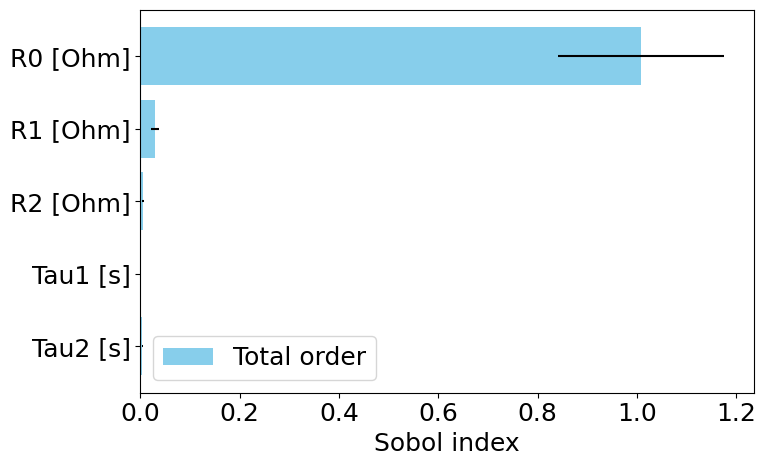

In [ ]:
plt.rcParams.update({"font.size": 18, "font.weight": "normal"})
plt.figure(figsize=(8, 5))
labels = salib_problem["names"]
plt.barh(labels, Si["ST"], xerr=Si["ST_conf"], color="skyblue", label="Total order")
# uncomment the below line to see first order indices
#plt.barh(labels, Si["S1"], xerr=Si["S1_conf"],  color="orange", alpha=0.7, label="First order")
plt.xlabel("Sobol index", fontweight="normal")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [34]:
# ===========================
# MORRIS SENSITIVITY ANALYSIS
# ===========================

# --- User settings ---
r = 10  # number of candidate trajectories (will generate r*(k+1) samples)
levels = 4  # number of grid levels for each parameter
optimal_k = 4  # number of optimal trajectories to select (< r)
fail_val = 1e5  # threshold to mark failed runs
seed = 123  # random seed for reproducibility

# Generate Morris samples
param_values_morris = morris_sample.sample(
    salib_problem,
    N=r,
    num_levels=levels,
    optimal_trajectories=optimal_k,
    local_optimization=False,
    seed=seed,
)
print("Morris sample generated:", param_values_morris.shape)

# Evaluate model for all samples
Y_morris = evaluate_samples(param_values_morris, verbose=True)
print("Model evaluations complete:", Y_morris.shape)

# Reshape into trajectories & identify failures
k = salib_problem["num_vars"]  # number of parameters
r_total = int(param_values_morris.shape[0] / (k + 1))

samples_reshaped = param_values_morris.reshape((r_total, k + 1, k))
Y_reshaped = Y_morris.reshape((r_total, k + 1))

traj_has_fail = np.any(Y_reshaped > fail_val, axis=1)
n_fail_traj = np.sum(traj_has_fail)
n_valid_traj = r_total - n_fail_traj

print(
    f"Total trajectories: {r_total}, Failed trajectories: {n_fail_traj}, Valid trajectories: {n_valid_traj}"
)

if n_valid_traj == 0:
    raise RuntimeError(
        "All trajectories failed — cannot compute Morris indices. "
        "Consider reducing penalty or tightening bounds."
    )

# Keep only valid trajectories
valid_idx = np.where(~traj_has_fail)[0]
samples_valid = samples_reshaped[valid_idx].reshape((n_valid_traj * (k + 1), k))
Y_valid = Y_reshaped[valid_idx].reshape((n_valid_traj * (k + 1),))

print("Valid samples shape:", samples_valid.shape, "Valid Y shape:", Y_valid.shape)

# Recompute Morris indices on valid trajectories
morris_res = morris_analyze.analyze(
    salib_problem, samples_valid, Y_valid, num_levels=levels, print_to_console=True
)

print("\nMorris mu* (clean):", morris_res["mu_star"])
print("Morris sigma (clean):", morris_res["sigma"])

Morris sample generated: (24, 5)
Eval 0/24, last Y=0.0700765, elapsed=0.2 s
Model evaluations complete: (24,)
Total trajectories: 4, Failed trajectories: 0, Valid trajectories: 4
Valid samples shape: (24, 5) Valid Y shape: (24,)
                mu   mu_star     sigma  mu_star_conf
R0 [Ohm]  0.298899  0.298899  0.000326      0.000273
R1 [Ohm]  0.053570  0.053570  0.005589      0.005178
R2 [Ohm]  0.022381  0.022381  0.016815      0.014366
Tau1 [s] -0.007001  0.007001  0.008087      0.007113
Tau2 [s] -0.011145  0.011145  0.007828      0.006477

Morris mu* (clean): [0.2988994486312202 0.05356990571278484 0.022381286013032853
 0.007000659882530232 0.011144902814611975]
Morris sigma (clean): [0.00032648 0.00558946 0.01681504 0.0080867  0.00782782]


### Plot the results of Morris's method.

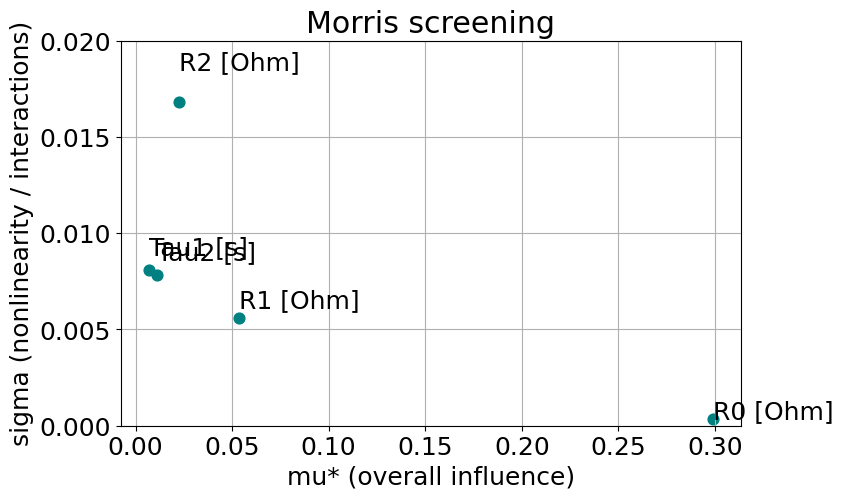

In [38]:
labels = salib_problem["names"]
plt.figure(figsize=(8, 5))
plt.scatter(morris_res["mu_star"], morris_res["sigma"], s=60, color="teal")
for i, txt in enumerate(labels):
    plt.text(morris_res["mu_star"][i] * 1, morris_res["sigma"][i] * 1.1, txt)
plt.ylim(0, 0.02)
plt.xlabel("mu* (overall influence)")
plt.ylabel("sigma (nonlinearity / interactions)")
plt.title("Morris screening")
plt.grid(True)
plt.show()

## Conclusion

This notebook illustrates how to extract EC parameters from an HPPC pulse using XNES in PyBOP, providing insights into the optimisation process through various visualisations. The estimated parameters are then used to run a thermal submodel. Further, the sensitivity analysis of the model is performed using methods of Sobol and Morris from the SALib module. The other methods from SALib can also be used. More information can be found: [here](https://salib.readthedocs.io/en/latest/).